In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
torch.cuda.is_available()

True

In [4]:
import os
os.chdir("/content/drive/My Drive/SSNE_repo/SSNE/miniprojekt2")

In [5]:
device = torch.device("cuda") 
device

device(type='cuda')

In [6]:
torch.manual_seed(42)

In [7]:
train_data = pd.read_csv('train_data.csv')

In [8]:
train_data['class'] = pd.cut(x=train_data['SalePrice'], bins=[train_data['SalePrice'].min() - 1, 100000, 350000, train_data['SalePrice'].max() + 1], labels=[0,1,2])

In [9]:
features = ['YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)',
       'N_Parkinglot(Basement)',  'N_manager',
       'N_elevators', 'N_FacilitiesInApt',
       'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
cat_features = ['HallwayType', 'HeatingType', 'AptManageType', 
                'TimeToBusStop', 'TimeToSubway', 'SubwayStation']
to_predict = ['class']

In [10]:
categorical_values = pd.get_dummies(train_data[cat_features])

In [11]:
train_indices = np.random.rand(len(train_data)) < 0.95

In [12]:
numerical_data = torch.from_numpy(train_data[features].values[train_indices]).float()
categorical_data = torch.from_numpy(categorical_values.values[train_indices]).float()
targets = torch.from_numpy(train_data[to_predict].values[train_indices].astype(np.dtype('int64')))

val_numerical_data = torch.from_numpy(train_data[features].values[~train_indices]).float()
val_categorical_data = torch.from_numpy(categorical_values.values[~train_indices]).float()
val_targets = torch.from_numpy(train_data[to_predict].values[~train_indices].astype(np.dtype('int64')))

In [13]:
categorical_data

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [14]:
train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
val_dataset = data.TensorDataset(val_numerical_data, val_categorical_data, val_targets)

In [15]:
next(iter(train_dataset))

(tensor([2006.,  814.,    3.,  111.,  184.,    3.,    0.,    5.,    6.,    9.]),
 tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0.]),
 tensor([1]))

In [16]:
# train_data

In [17]:
train_data.columns

Index(['SalePrice', 'YearBuilt', 'Size(sqf)', 'Floor', 'HallwayType',
       'HeatingType', 'AptManageType', 'N_Parkinglot(Ground)',
       'N_Parkinglot(Basement)', 'TimeToBusStop', 'TimeToSubway', 'N_manager',
       'N_elevators', 'SubwayStation', 'N_FacilitiesInApt',
       'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)', 'class'],
      dtype='object')

In [18]:
# train_data

In [19]:
# fig = plt.figure(figsize = (15,20))
# ax = fig.gca()
# train_data.hist(ax=ax)

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(33, 20)
        self.bn1 = nn.BatchNorm1d(20)
        self.act_1 =  nn.ReLU()
        self.d1 = nn.Dropout(0.1)
        self.layer2 = nn.Linear(20, 40)
        self.bn2 = nn.BatchNorm1d(40)
        self.act_2 = nn.ReLU()
        self.d2 = nn.Dropout(0.1)
        self.layer3 = nn.Linear(40, 10)
        self.bn3 = nn.BatchNorm1d(10)
        self.act_3 = nn.ReLU()
        self.d3 = nn.Dropout(0.1)
        self.layer4 = nn.Linear(10, 3)
        self.act_4 = nn.ReLU()
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        # print(x)
        x = self.d1(self.act_1(self.bn1(self.layer1(x))))
        x = self.d2(self.act_2(self.bn2(self.layer2(x))))
        x = self.d3(self.act_3(self.bn3(self.layer3(x))))
        x = self.layer4(x)
        # x = self.softmax(x)
        return x

In [21]:
# def get_accuracy(model, data):
#     correct = 0
#     total = 0
#     model.eval()
#     for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
#         # imgs, labels = imgs.to(device), labels.to(device)
#         output = model(imgs)
#         # print('OUT', output)
#         pred = output.max(1, keepdim=True)[1] # get the index of the max logit
#         # print('PRED', pred)
#         correct += pred.eq(labels.view_as(pred)).sum().item()
#         total += imgs.shape[0]
#     return correct / total

In [22]:
model = Classifier()

In [23]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for x, cat_x, labels in torch.utils.data.DataLoader(data, batch_size=64):
        # moving to device
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)

        output = model(x, cat_x)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]
    return correct / total

In [24]:
def train(model, train, valid, batch_size=64, num_epochs=1, learn_rate=0.01, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=learn_rate, weight_decay=weight_decay )
#     optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    epochs, losses, train_acc, val_acc = [], [], [], []

    # training
#     n = 0 # the number of iterations

    model = model.to(device)
    # train = train.to(device)
    # valid = valid.to(device)

    for n in range(num_epochs):
        epoch_loss = 0
        train_accuracy = 0
        val_accuracy = 0
        printing = True
        for x, cat_x, labels in iter(train_loader):
            model.train()
            # moving to GPU
            x = x.to(device)
            cat_x = cat_x.to(device)
            labels = labels.to(device)
            out = model(x, cat_x).unsqueeze(dim=2)         # forward pass
            # print('OUT', out)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         

            # save the current training information
            
            epoch_loss += float(loss)
            # losses.append(float(loss)/batch_size)        # compute *average* loss
            # train_acc.append(get_accuracy(model, train)) # compute training accuracy 
            # val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            train_accuracy += get_accuracy(model, train)
            val_accuracy += get_accuracy(model, valid)
            
            
        losses.append(epoch_loss/(batch_size * len(train_loader)))
        epochs.append(n)
        train_acc.append(train_accuracy/len(train_loader))
        val_acc.append(val_accuracy/len(train_loader))
        
        if n%10==0:
            print(f"Epoch {n}")
        
    
    plot_results(epochs, losses, train_acc, val_acc)

            

In [25]:
def plot_results(epochs, losses, train_acc, val_acc):
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 160
Epoch 170
Epoch 180
Epoch 190
Epoch 200
Epoch 210
Epoch 220
Epoch 230
Epoch 240
Epoch 250
Epoch 260
Epoch 270
Epoch 280
Epoch 290
Epoch 300
Epoch 310
Epoch 320
Epoch 330
Epoch 340
Epoch 350
Epoch 360
Epoch 370
Epoch 380
Epoch 390
Epoch 400
Epoch 410
Epoch 420
Epoch 430
Epoch 440
Epoch 450
Epoch 460
Epoch 470
Epoch 480
Epoch 490


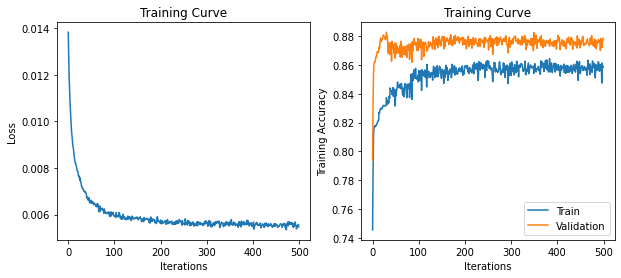

Final Training Accuracy: 0.8587787221177103
Final Validation Accuracy: 0.8786140089418778
CPU times: user 40min 47s, sys: 8.5 s, total: 40min 55s
Wall time: 40min 54s


In [26]:
%%time
train(model, train_dataset, val_dataset, num_epochs=500, learn_rate=0.0002, weight_decay=0.02)

In [27]:
# saving model to file
state_dict = model.state_dict()
torch.save(state_dict, "neural_net.tar")

In [28]:
# testing
test_data = pd.read_csv('test_data.csv')

In [29]:
categorical_values_test = pd.get_dummies(test_data[cat_features])

In [30]:
numerical_data_test = torch.from_numpy(test_data[features].values).float()
categorical_data_test = torch.from_numpy(categorical_values_test.values).float()

In [31]:
numerical_data_test,categorical_data_test = numerical_data_test.to(device), categorical_data_test.to(device)

In [32]:
# predictions for test
pred = model(numerical_data_test, categorical_data_test)
pred = pred.max(1, keepdim=True)[1]

In [33]:
# report for valid
val_numerical_data, val_categorical_data = val_numerical_data.to(device), val_categorical_data.to(device)

In [34]:
# predictions for test
pred_val = model(val_numerical_data, val_categorical_data)
pred_val = pred_val.max(1, keepdim=True)[1]

In [35]:
# report
from sklearn.metrics import classification_report
print(classification_report(pred_val.cpu(), val_targets))

              precision    recall  f1-score   support

           0       0.56      0.82      0.67        17
           1       0.94      0.91      0.92       176
           2       0.80      0.74      0.77        27

    accuracy                           0.88       220
   macro avg       0.77      0.82      0.79       220
weighted avg       0.89      0.88      0.89       220

